### Here we try to compare differences of blockings using different regridding methods

In [3]:
from contrack import contrack
import xarray as xr
import datetime
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from matplotlib import cm
import sys, os, argparse

In [46]:
### blocking method based on the original Code of Daniel Steinfeld 
#xr_in = xr.open_mfdataset('/scratch/b/b382006/ifs/from_9km_to_1degree/Y*/ICMUAhr2n+0*',concat_dim='time',combine='nested')
xr_in=xr.open_mfdataset('/work/bm1235/b382006/regridding/icon/from_5km_to_1degre/raw/ngc2009_atm_pl_6h_inst_20200*')

In [47]:
## rename zfull
xr_in=xr_in.rename({'zfull':'z_height'})
xr_in

,Array,Chunk
Bytes,3.08 GiB,12.85 MiB
Shape,"(982, 13, 180, 360)","(4, 13, 180, 360)"
Count,750 Tasks,250 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,3.08 GiB,12.85 MiB
Shape,"(982, 13, 180, 360)","(4, 13, 180, 360)"
Count,750 Tasks,250 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [48]:
### Take geopotential
in_z_500=xr_in.z_height.sel(plev=50000.0)
z_dataset=xr.DataArray.to_dataset(in_z_500)
z_dataset

<xarray.Dataset>
Dimensions:   (time: 982, lon: 360, lat: 180)
Coordinates:
  * time      (time) datetime64[ns] 2020-01-19 ... 2020-09-29T18:00:00
  * lon       (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * lat       (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
    plev      float64 5e+04
Data variables:
    z_height  (time, lat, lon) float32 dask.array<chunksize=(4, 180, 360), meta=np.ndarray>

In [49]:
### intitate
block = contrack()
block.read_xarray(z_dataset)

In [50]:
# select only winter months January, February and December/ geopotential (z) / plev at 500 hPa
#block.ds = block.ds.sel(time=block.ds.time.dt.month.isin([1, 2, 12]))
#block.ds

In [51]:
## calculate geopotential height
#block.calculate_gph_from_gp(gp_name='z',
#                            gp_unit='m**2 s**-2',
#                            gph_name='z_height')

# Hint: Use block.set_up(...) to do consistency check and set (automatically or manually) names of dimension ('time', 'latitude', 'longitude')
block.set_up(force=True)
block.ds = block.ds.compute() ### look at this!
#block.time

            Hint: use set_up(force=True).
INFO: 
 time: 'time'
 longitude: 'lon'
 latitude: 'lat'



In [52]:
# calculate Z500 anomaly (temporally smoothed with a 2 d running mean) with respect to the 31-day running mean (long-term: 30 years) climatology
block.calc_anom(variable='z_height',
                smooth=8,
                window=31,
                groupby='dayofyear')

INFO: Set up dimensions...
INFO: 
 time: 'time'
 longitude: 'lon'
 latitude: 'lat'

INFO: Calculating climatological mean from z_height...
INFO: Calculating Anomaly... DONE


In [53]:
# Hint: Use 'clim=...' to point towards an existing climatological mean (useful for weather forecasts)
# output: variable 'anom'.

# Finally, track blocking anticyclones (>=150gmp, 50% overlap twosided, 5 timesteps persistence (here 5 days))
block.run_contrack(variable='anom',
                   threshold=160,
                   gorl='>=',
                   overlap=0.7,
                   persistence=20,
                   twosided=True)

INFO: 
Run ConTrack 
########### 
    threshold:    >= 160 
    overlap:      0.7 
    persistence:  20 time steps
INFO: Set up dimensions...
INFO: 
 time: 'time'
 longitude: 'lon'
 latitude: 'lat'

INFO: Find individual contours...
INFO: Apply overlap...
INFO: Apply persistence...
INFO: Create new variable 'flag'...
INFO: Running contrack... DONE
31 contours tracked


In [54]:
# output: variable 'flag'. 440 blocking systems tracked. Each blocking system is identified by a unique flag/ID.
#block.anom=block.anom.where(block['anom']==np.nan, -999.9)
#block.anom.isel(time=[1]).values
#block.anom.isel(time=[4]).plot()
block

#weight_lat = np.cos(block.ds['lat'].data*np.pi/180)
#weight_grid = np.ones((block.ds.dims['lat'], block.ds.dims['lon'])) * np.array((111 * block._dlat * 111 * block._dlon * weight_lat)).astype(np.float32)[:, None]               
#for i_time in range(block.ds.dims['time']): 
#    currentstep = block.ds['time'].isel(**{'time': i_time}).dt.strftime('%Y%m%d_%H').values    
#    # loop over individual contours
#    labels = np.unique(block.ds['flag'].isel(**{'time': i_time}).data)
#    labels = labels[labels != 0]
#    print(labels)
#    if len(labels) == 0:
#        continue        
#    for label in labels:
#                # calculate area and intensity
#        areacon = np.sum(weight_grid[block.ds['flag'].isel(**{'time': i_time}).data == label])
###     intensitycon = np.sum(weight_grid[self.ds[flag].isel(**{self._time_name: i_time}).data == label] * self.ds[variable].isel(**{self._time_name: i_time}).data[self.ds[flag].isel(**{self._time_name: i_time}).data == label])
#        intensitycon = np.sum(weight_grid[block.ds['flag'].isel(**{'time': i_time}).data == label] * block.ds['anom'].isel(**{'time': i_time}).data[block.ds['flag'].isel(**{'time': i_time}).data == label])
#        intensitycon1 = weight_grid[block.ds['flag'].isel(**{'time': i_time}).data == label]
#        intensitycon2 = block.ds['anom'].isel(**{'time': i_time}).data[block.ds['flag'].isel(**{'time': i_time}).data == label]
#        print(label, np.shape(intensitycon1), intensitycon2)
#        print(intensitycon2)

Xarray dataset with 982 time steps. 
            Available fields: z_height, anom, flag

In [55]:
# Out[]:     Xarray dataset with 2707 time steps.
#            Available fields: z, z_height, anom, flag

# Hint: In case you want to use a more objective threshold, e.g., the 90th percentile of the Z500 anomaly winter distribution over 50°-80°N, do:
# threshold = block['anom'].sel(latitude=slice(80, 50)).quantile([0.90], dim='time').mean() # 177gmp

# save to disk
block['flag'].to_netcdf('/scratch/b/b382006/flag.nc')

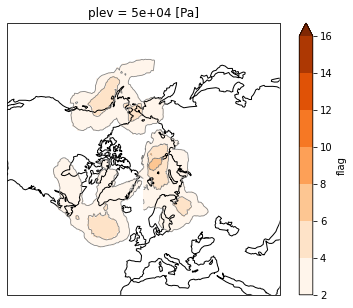

In [56]:
# plotting blocking frequency (in %) for winter over Northern Hemisphere
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

fig, ax = plt.subplots(figsize=(7, 5), subplot_kw={'projection': ccrs.NorthPolarStereo()})
(xr.where(block['flag']>1,1,0).sum(dim='time')/block.ntime*100).plot(levels=np.arange(2,18,2), cmap='Oranges', extend = 'max', transform=ccrs.PlateCarree())
(xr.where(block['flag']>1,1,0).sum(dim='time')/block.ntime*100).plot.contour(colors='grey', linewidths=0.8, levels=np.arange(2,18,2), transform=ccrs.PlateCarree())
ax.set_extent([-180, 180, 30, 90], crs=ccrs.PlateCarree()); ax.coastlines();
#plt.show()

In [57]:
# flag = output of block.run_contrack(), variable = input variable to calculate intensity and center of mass
block_df = block.run_lifecycle(flag='flag', variable='anom')
#block_df.to_csv(outdir_table+'/'+outfile_table, index=False)

# output is a pandas.DataFrame
block_df

INFO: 
Run Lifecycle 
########### 
    flag:    flag
    variable:    anom
INFO: Set up dimensions...
INFO: 
 time: 'time'
 longitude: 'lon'
 latitude: 'lat'



,Flag,Date,Longitude,Latitude,Intensity,Size
0,1,20200120_00,162,-55,272.21,76395943.87
1,1,20200120_06,163,-55,273.31,76834768.36
2,1,20200120_12,164,-55,273.50,77654980.60
3,1,20200120_18,166,-55,272.89,78613151.83
4,1,20200121_00,167,-55,271.74,79727906.10
...,...,...,...,...,...,...
1094,830,20200924_18,237,53,192.79,1978555.05
1095,830,20200925_00,238,53,191.46,1910778.49
1096,830,20200925_06,240,53,188.79,1744754.77
1097,830,20200925_12,242,52,184.22,1548409.41


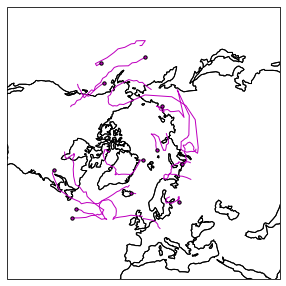

In [58]:
# plotting blocking track (center of mass) and genesis
f, ax = plt.subplots(1, 1, figsize=(7,5), subplot_kw=dict(projection=ccrs.NorthPolarStereo()))
ax.set_extent([-180, 180, 30, 90], crs=ccrs.PlateCarree()); ax.coastlines()
ax.coastlines() # add coastlines

#need to split each blocking track due to longitude wrapping (jumping at map edge)
for bid in np.unique(np.asarray(block_df['Flag'])): #select blocking id
    lons = np.asarray(block_df['Longitude'].iloc[np.where(block_df['Flag']==bid)])
    lats = np.asarray(block_df['Latitude'].iloc[np.where(block_df['Flag']==bid)])

    # cosmetic: sometimes there is a gap near map edge where track is split:
    lons[lons >= 355] = 359.9
    lons[lons <= 3] = 0.1
    segment = np.vstack((lons,lats))

    #move longitude into the map region and split if longitude jumps by more than "threshold"
    lon0 = 0 #center of map
    bleft = lon0-0.
    bright = lon0+360
    segment[0,segment[0]> bright] -= 360
    segment[0,segment[0]< bleft]  += 360
    threshold = 180  # CHANGE HERE
    isplit = np.nonzero(np.abs(np.diff(segment[0])) > threshold)[0]
    subsegs = np.split(segment,isplit+1,axis=+1)

    #plot the tracks
    for seg in subsegs:
        x,y = seg[0],seg[1]
        ax.plot(x ,y,c = 'm',linewidth=1, transform=ccrs.PlateCarree())
    #plot the starting points
    ax.scatter(lons[0],lats[0],s=11,c='m', zorder=10, edgecolor='black', transform=ccrs.PlateCarree())